# Classifying 2D data points with Multilayer Perceptron (MLP)

In [1]:
using AutoDiff

import Plots: scatter
import Distributions: Normal
import Random: shuffle

## Create the dataset

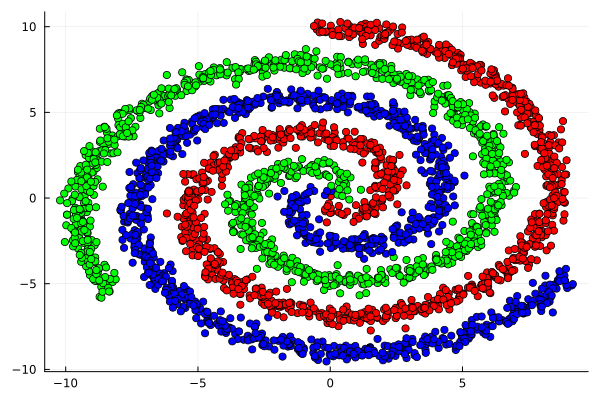

In [2]:
# The following helper code for creating dataset is generated by ChatGPT
# Helper function to create a single spiral arm
function create_spiral_arm(n_points, arm_index, n_arms, noise_level)
    # Initialize arrays
    x = zeros(n_points)
    y = zeros(n_points)
    labels = fill(arm_index, n_points)

    # Constants to control the spiral arms
    theta_offset = 2 * π * arm_index / n_arms
    max_radius = 10

    for i in 1:n_points
        # Generate points along a spiral arm
        radius = max_radius * sqrt(i / n_points)
        theta = radius + theta_offset
        x[i] = radius * cos(theta)
        y[i] = radius * sin(theta)

        # Add random noise
        x[i] += rand(Normal(0, noise_level))
        y[i] += rand(Normal(0, noise_level))
    end

    return hcat(x, y, labels)
end

n_points_per_arm = 1000  # Number of points per arm
n_arms = 3               # Number of arms
noise_level = 0.3        # Noise level

# Generate the spiral data
data = vcat([create_spiral_arm(n_points_per_arm, i, n_arms, noise_level) for i in 1:n_arms]...)

# Shuffle the data
data = data[shuffle(1:end), :]
data, labels = data[:, 1:2], data[:, 3]

# Plot
scatter(data[:, 1], data[:, 2], marker_z=labels, color=:brg, legend=false)

## Train the classifier with AutoDiff engine